# **STEP 0: IMPORT LIBRARIES**

In [93]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import FeatureUnion
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer  
from sklearn.preprocessing import OneHotEncoder      
from sklearn.model_selection import KFold   
from sklearn.decomposition import PCA
from sklearn.feature_selection import mutual_info_regression
from statistics import mean
from sklearn.model_selection import train_test_split
import joblib 
import lightgbm as lgb
from xgboost import XGBRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import ShuffleSplit, StratifiedKFold, StratifiedShuffleSplit
from sklearn.model_selection import cross_val_predict
from sklearn.model_selection import KFold, StratifiedKFold

# Additional useful imports
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.preprocessing import LabelEncoder
from sklearn.compose import ColumnTransformer
from sklearn.impute import KNNImputer
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.feature_selection import SelectKBest, f_regression
from sklearn.model_selection import learning_curve
from sklearn.inspection import permutation_importance
from sklearn.metrics import mean_absolute_error, median_absolute_error
import seaborn as sns
from scipy import stats
import warnings
import os
import yfinance as yf
import ta

# **STEP 1: DEFINE LABEL**

In [94]:
forex_label = ['GBPJPY=X'] # You can update by adding more

# **STEP 2: GET FOREX DATA CRAWLING**

**2.1: Crawl all FOREX data needed**

**2.1.1. Function to crawl Forex data**

In [95]:
def crawl_forex_data(forex_pair, directory='Dataset'):
    """
    Crawls historical data for a given Forex pair and saves it to a CSV file.

    Parameters:
    forex_pair (str): The Forex pair symbol to download data for (e.g., 'EURUSD=X').
    directory (str): The directory where the data should be saved.

    Returns:
    str: Path to the saved CSV file.
    pd.DataFrame: The crawled data as a Pandas DataFrame.
    """
    # Create directory if it doesn't exist
    if not os.path.exists(directory):
        os.makedirs(directory)

    # Download historical data for the Forex pair
    print(f"Downloading data for {forex_pair}...")
    data = yf.download(forex_pair, period="max", interval='1d')
    data.reset_index(inplace=True)  # Reset index to ensure 'Date' is a normal column

    # Save data to CSV
    file_path = os.path.join(directory, f'{forex_pair}_data.csv')
    data.to_csv(file_path, index=False)
    print(f"Saved data for {forex_pair} at {file_path}")

    return file_path, data

**2.2. Check crawling result**

In [96]:
file_path, data = crawl_forex_data(forex_label)

# Display the first 10 rows of the DataFrame
print(data.head(5))

# Calculate and print statistics of NaN values
nan_stats = data.isna().sum()
total_nans = nan_stats.sum()

print("\nStatistics of NaN values in the DataFrame:")
print(nan_stats)
print(f"\nTotal number of NaN values: {total_nans}")

[*********************100%***********************]  1 of 1 completed

Saved data for ['GBPJPY=X'] at Dataset\['GBPJPY=X']_data.csv
        Date       Open       High        Low      Close  Adj Close  Volume
0 2003-12-01 189.330002 189.660004 187.740005 187.630005 187.630005       0
1 2003-12-02 187.669998 188.809998 187.559998 188.009995 188.009995       0
2 2003-12-03 188.020004 188.240005 186.490005 187.089996 187.089996       0
3 2003-12-04 187.029999 187.029999 185.899994 186.220001 186.220001       0
4 2003-12-05 186.190002 186.740005 185.830002 185.880005 185.880005       0

Statistics of NaN values in the DataFrame:
Date         0
Open         0
High         0
Low          0
Close        0
Adj Close    0
Volume       0
dtype: int64

Total number of NaN values: 0


**STEP 3: FEATURE ENGINEERING**

In [97]:
# Feature Engineering 
# Calculate moving averages
if 'Close' in data.columns:
    if len(data) >= 10: data['MA_10'] = data['Close'].rolling(window=10).mean()
    if len(data) >= 50: data['MA_50'] = data['Close'].rolling(window=50).mean()
    if len(data) >= 200: data['MA_200'] = data['Close'].rolling(window=200).mean()

# Calculate RSI
data['RSI'] = ta.momentum.RSIIndicator(data['Close'], window=14).rsi()

# Calculate MACD
data['MACD'] = ta.trend.MACD(data['Close']).macd()

# Calculate Bollinger Bands
bollinger = ta.volatility.BollingerBands(data['Close'])
data['BB_High'] = bollinger.bollinger_hband()
data['BB_Low'] = bollinger.bollinger_lband()

# Calculate Bollinger BandWidth (BBTrend)
data['BB_Width'] = (data['BB_High'] - data['BB_Low']) / data['Close']

# 24-hour Volume
data['Volume_24h'] = data['Volume'].rolling(window=1440).sum()

# Accumulation/Distribution Line (ADL)
data['ADL'] = ta.volume.AccDistIndexIndicator(data['High'], data['Low'], data['Close'], data['Volume']).acc_dist_index()

# Aroon Indicator
aroon = ta.trend.AroonIndicator(data['Close'], data['Low'], window=25)
data['Aroon_Up'] = aroon.aroon_up()
data['Aroon_Down'] = aroon.aroon_down()

# Average Directional Index (ADX)
data['ADX'] = ta.trend.ADXIndicator(data['High'], data['Low'], data['Close'], window=14).adx()

# Average True Range (ATR)
data['ATR'] = ta.volatility.AverageTrueRange(data['High'], data['Low'], data['Close'], window=14).average_true_range()

# Awesome Oscillator (AO)
data['AO'] = ta.momentum.AwesomeOscillatorIndicator(data['High'], data['Low'], window1=5, window2=34).awesome_oscillator()

# Balance of Power (BOP)
data['BOP'] = (data['Close'] - data['Open']) / (data['High'] - data['Low'])

# Bull Bear Power
data['Bull_Power'] = data['High'] - data['MA_50']
data['Bear_Power'] = data['Low'] - data['MA_50']

# Chaikin Oscillator
data['Chaikin_Osc'] = data['ADL'].ewm(span=3).mean() - data['ADL'].ewm(span=10).mean()

# Stochastic Oscillator (Stoch)
stoch = ta.momentum.StochasticOscillator(data['High'], data['Low'], data['Close'], window=14)
data['Stoch_Osc'] = stoch.stoch()

# Commodity Channel Index (CCI)
data['CCI'] = ta.trend.CCIIndicator(data['High'], data['Low'], data['Close'], window=20).cci()

# Vortex Oscillator
vortex = ta.trend.VortexIndicator(data['High'], data['Low'], data['Close'], window=14)
data['Vortex_Plus'] = vortex.vortex_indicator_pos()
data['Vortex_Minus'] = vortex.vortex_indicator_neg()

**3.2. Check NaN values before interpolation**

In [98]:
nan_stats_before = data.isna().sum()
total_nans_before = nan_stats_before.sum()
print("\nStatistics of NaN values before interpolation:")
print(nan_stats_before)
print(f"Total number of NaN values before interpolation: {total_nans_before}")


Statistics of NaN values before interpolation:
Date               0
Open               0
High               0
Low                0
Close              0
Adj Close          0
Volume             0
MA_10              9
MA_50             49
MA_200           199
RSI               13
MACD              25
BB_High           19
BB_Low            19
BB_Width          19
Volume_24h      1439
ADL                0
Aroon_Up          25
Aroon_Down        25
ADX                0
ATR                0
AO                33
BOP               13
Bull_Power        49
Bear_Power        49
Chaikin_Osc        0
Stoch_Osc         13
CCI               19
Vortex_Plus       14
Vortex_Minus      14
dtype: int64
Total number of NaN values before interpolation: 2045


**3.3. Use Interpolation to fill missing values**

**Why use Interpolation ?**

In [99]:
# Interpolate missing data
data.interpolate(method='linear', inplace=True)

In [100]:
# Check how many rows remain after interpolation
nan_stats_after = data.isna().sum()
total_nans_after = nan_stats_after.sum()
print("\nStatistics of NaN values after interpolation:")
# print(nan_stats_after)
print(f"Total number of NaN values after interpolation: {total_nans_after}")


Statistics of NaN values after interpolation:
Total number of NaN values after interpolation: 2032


**NOTE: As we can see, after using the interpolation, there are still many NaN values**

**3.4: Detect NaN values left and fill them**

In [101]:
# If there are still NaN values, use another method to fill them
if total_nans_after > 0:
    # Fill remaining NaN values with forward fill
    data.fillna(method='ffill', inplace=True)
    
    # If still NaN, use backward fill
    if data.isna().sum().sum() > 0:
        data.fillna(method='bfill', inplace=True)

C:\Users\Admin\AppData\Local\Temp\ipykernel_25752\1693104163.py:4: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  data.fillna(method='ffill', inplace=True)
C:\Users\Admin\AppData\Local\Temp\ipykernel_25752\1693104163.py:8: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  data.fillna(method='bfill', inplace=True)


**3.5. Examine for left over NaN result**

In [102]:
# Final check on NaN values
nan_stats_final = data.isna().sum()
total_nans_final = nan_stats_final.sum()
print("\n----Statistics of NaN values after final filling----")
print(f"Total number of NaN values after final filling: {total_nans_final}")

# Check how many rows remain after dropping NaN values
data.dropna(subset=['Close', 'Open'], inplace=True)
print(f"Number of rows after dropna: {len(data)}")


----Statistics of NaN values after final filling----
Total number of NaN values after final filling: 0
Number of rows after dropna: 5420


**3.6. Define list of indicators**

In [103]:
# List of indicators to plot
indicators = [
    'MA_10', 'MA_50', 'MA_200',
    'RSI', 'MACD',
    'BB_High', 'BB_Low',
    'ADX', 'ATR', 'AO',
    'BOP', 'Bull_Power', 'Bear_Power',
    'Chaikin_Osc',
    'Stoch_Osc', 'CCI',
    'Vortex_Plus', 'Vortex_Minus'
    ]

**STEP 4: PLOTTING FOR EVALUATION**

**Function to plot year data**

In [104]:
def plot_yearly_data(data, title='Yearly Price Data'):
    plt.figure(figsize=(14, 7))
    plt.plot(data['Date'], data['Close'], label='Close Price', color='blue')
    plt.title(title)
    plt.xlabel('Date')
    plt.ylabel('Price')
    plt.legend()
    plt.grid()
    plt.show()

**Functions to plot prices vs indicators**

In [105]:
def plot_prices_vs_indicators(data, indicator, title):
    plt.figure(figsize=(14, 7))
    plt.plot(data['Date'], data['Close'], label='Close Price', color='blue')
    plt.plot(data['Date'], data[indicator], label=indicator, color='orange')
    plt.title(title)
    plt.xlabel('Date')
    plt.ylabel('Price / Indicator Value')
    plt.legend()
    plt.grid()
    plt.show()

**Function to plot out Label Price vs other forex pairs**

In [106]:
# **Function to plot out Label Price vs Other Forex Pairs**
def plot_label_vs_other_forex(data, label, other_pairs):
    plt.figure(figsize=(14, 7))
    
    # Check if the label exists in the DataFrame
    if label not in data.columns:
        print(f"Label '{label}' not found in DataFrame columns: {data.columns}")
        return

    plt.plot(data['Date'], data[label], label=label, color='blue')
    
    for pair in other_pairs:
        pair_close = f'{pair}_Close'
        if pair_close in data.columns:  # Ensure the pair exists in the DataFrame
            plt.plot(data['Date'], data[pair_close], label=f'{pair} Close', linestyle='--')
    
    plt.title(f'{label} vs Other Forex Pairs')
    plt.xlabel('Date')
    plt.ylabel('Price')
    plt.legend()
    plt.grid()
    plt.show()

**4.1. Plot out yearly data**

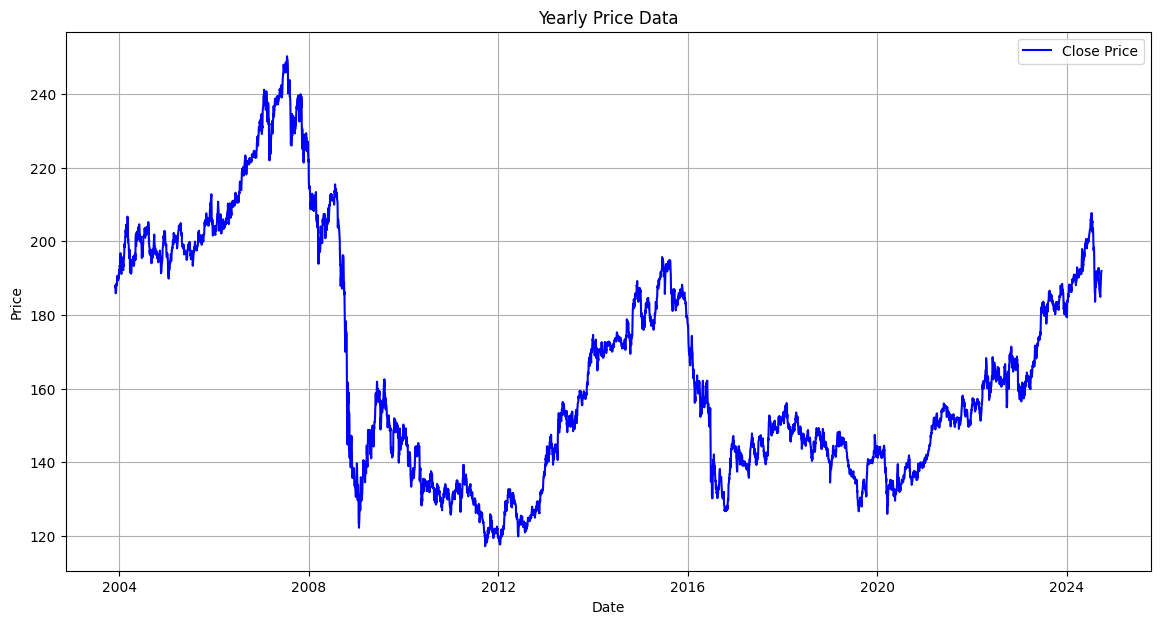

In [107]:
# Plot yearly data
plot_yearly_data(data)

**4..2. Plot out indicators vs price**

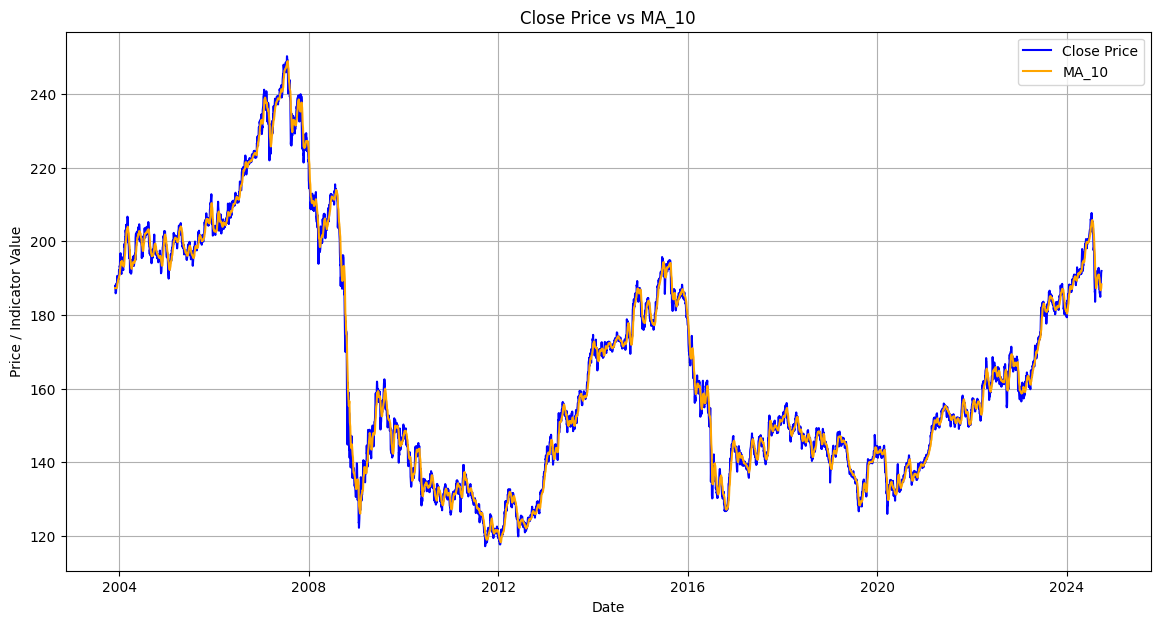

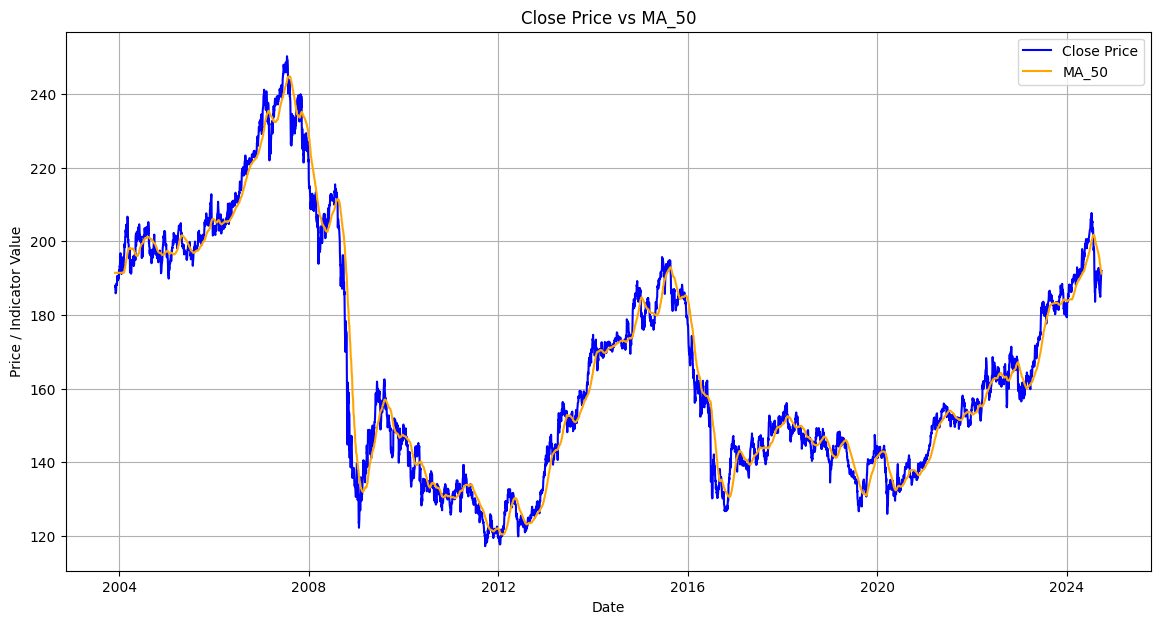

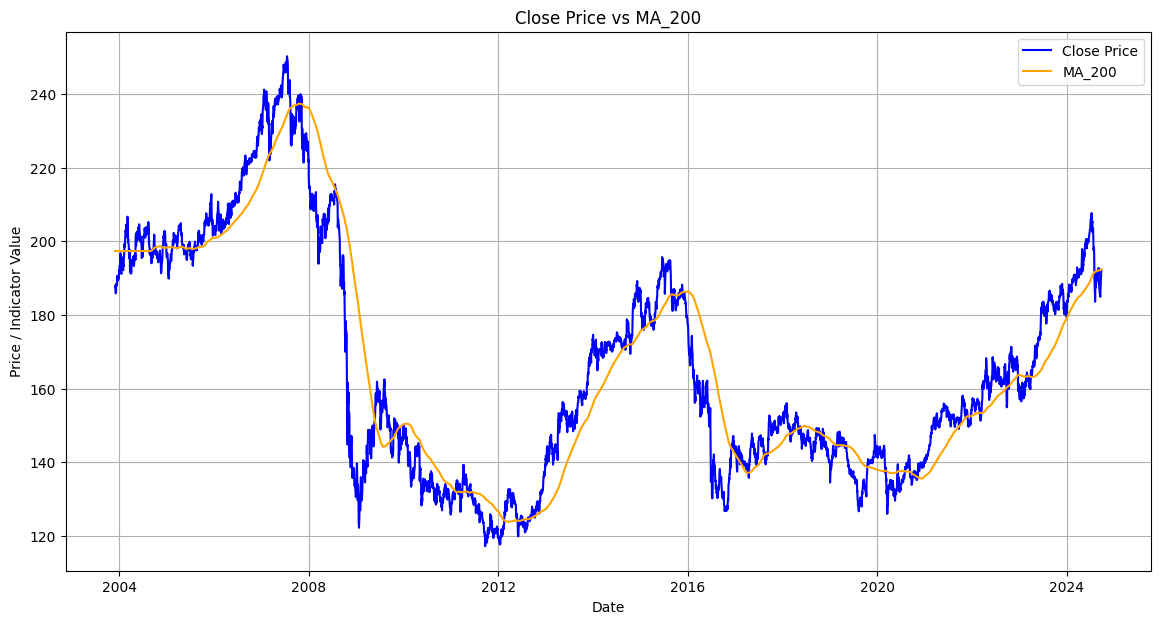

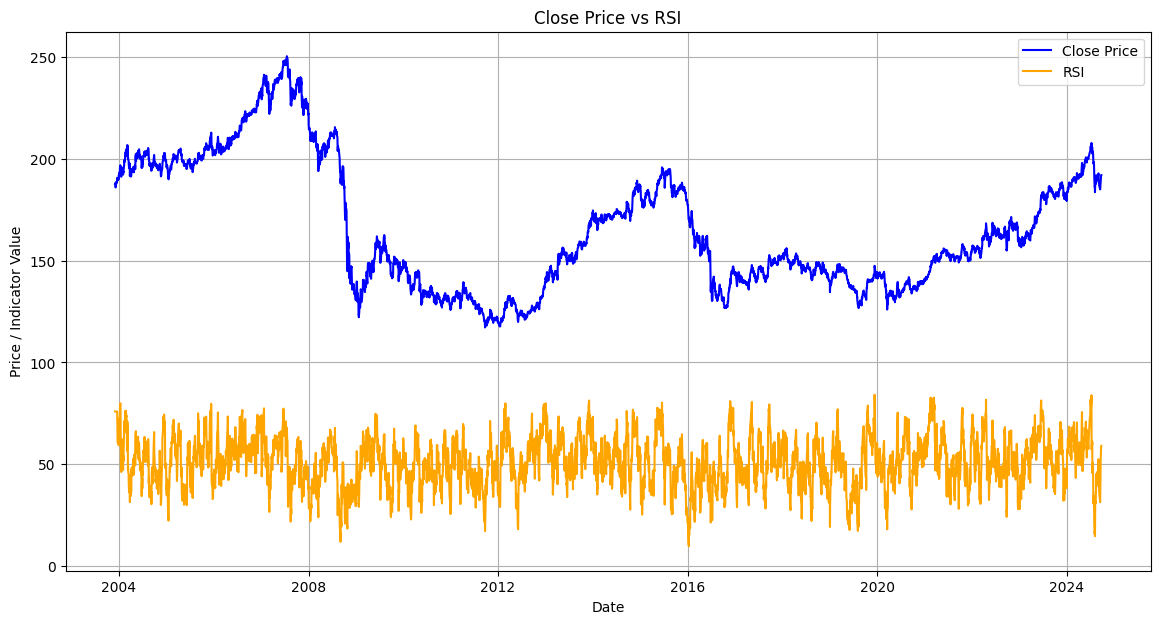

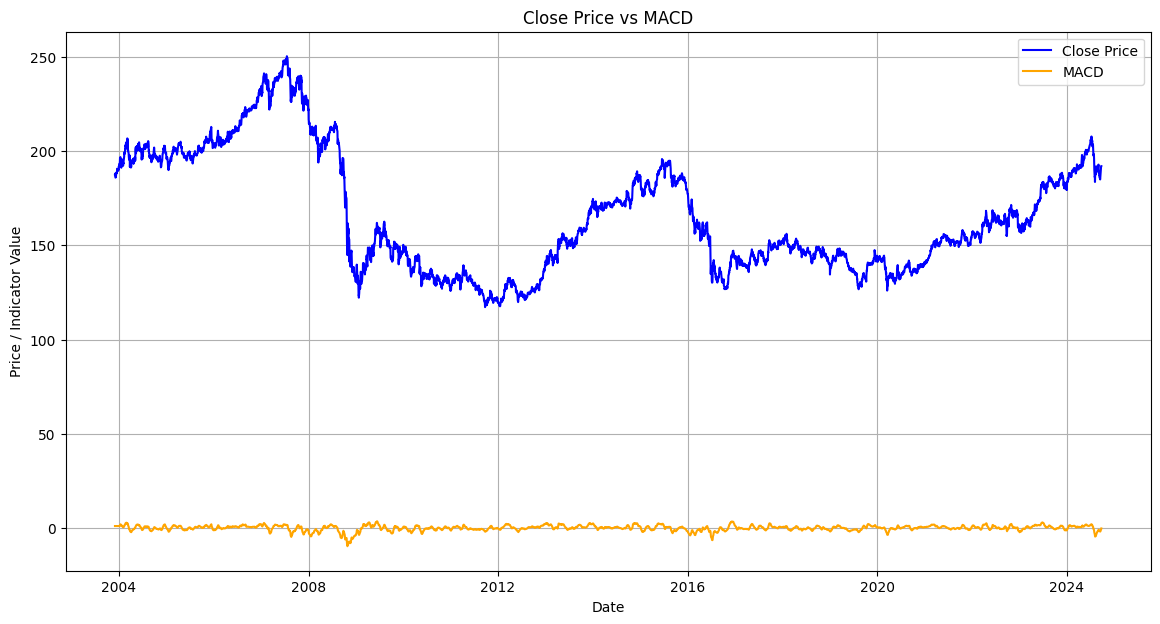

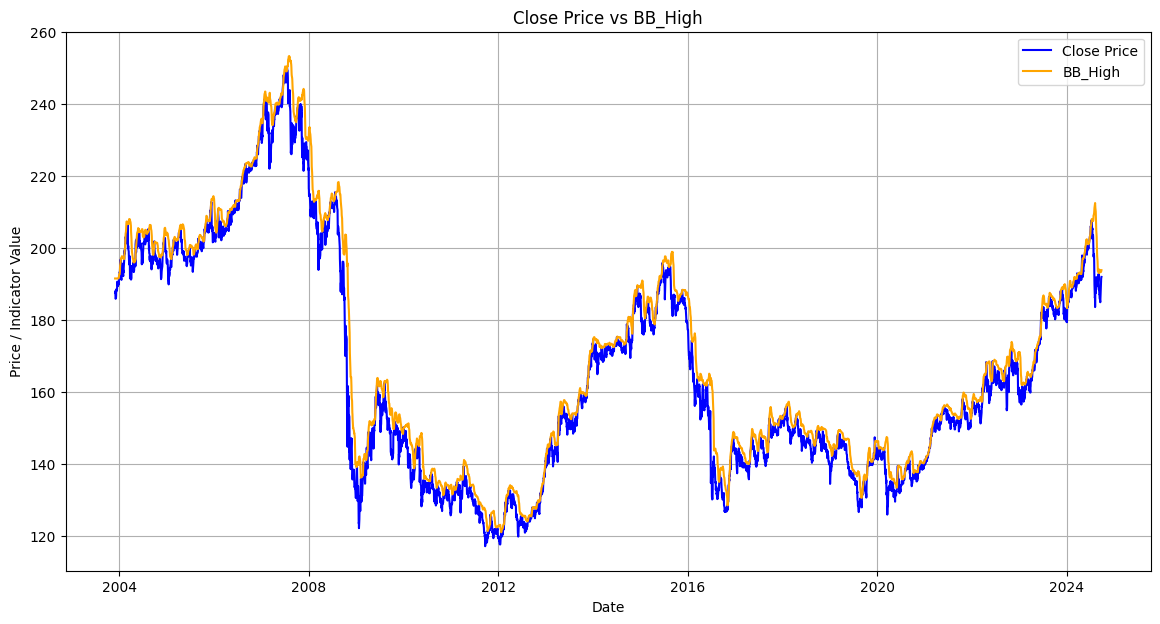

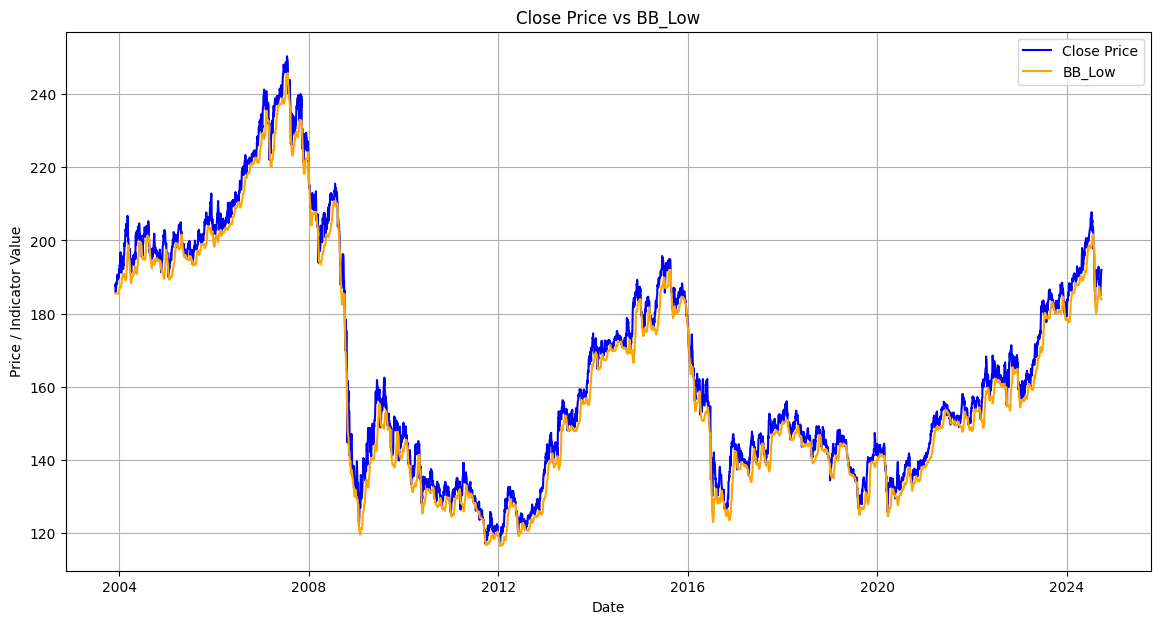

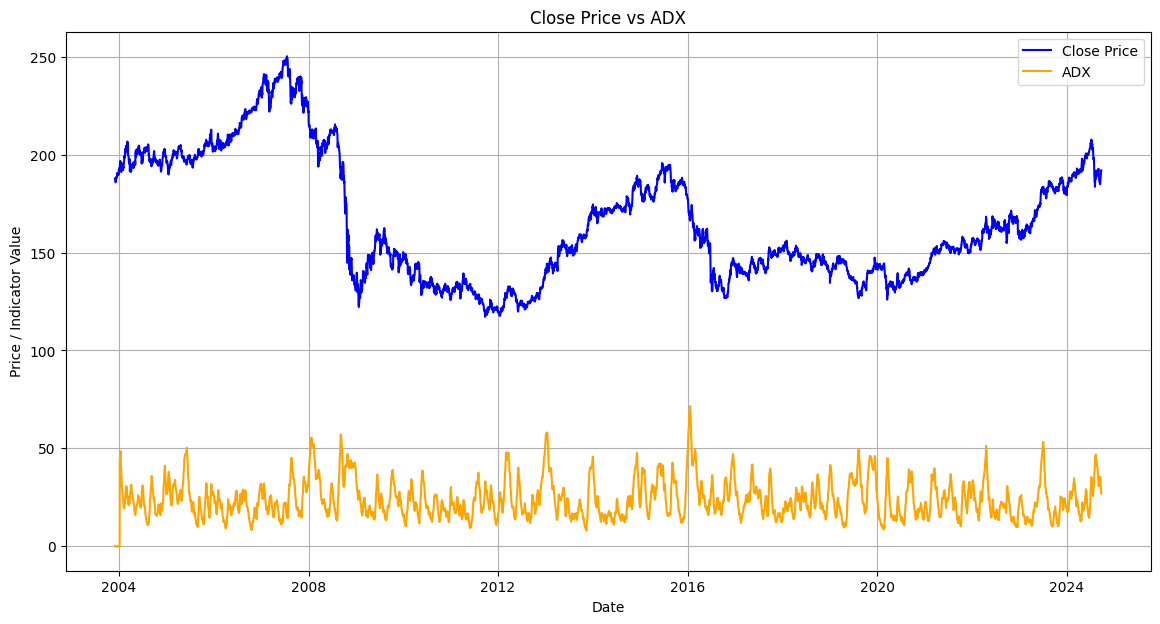

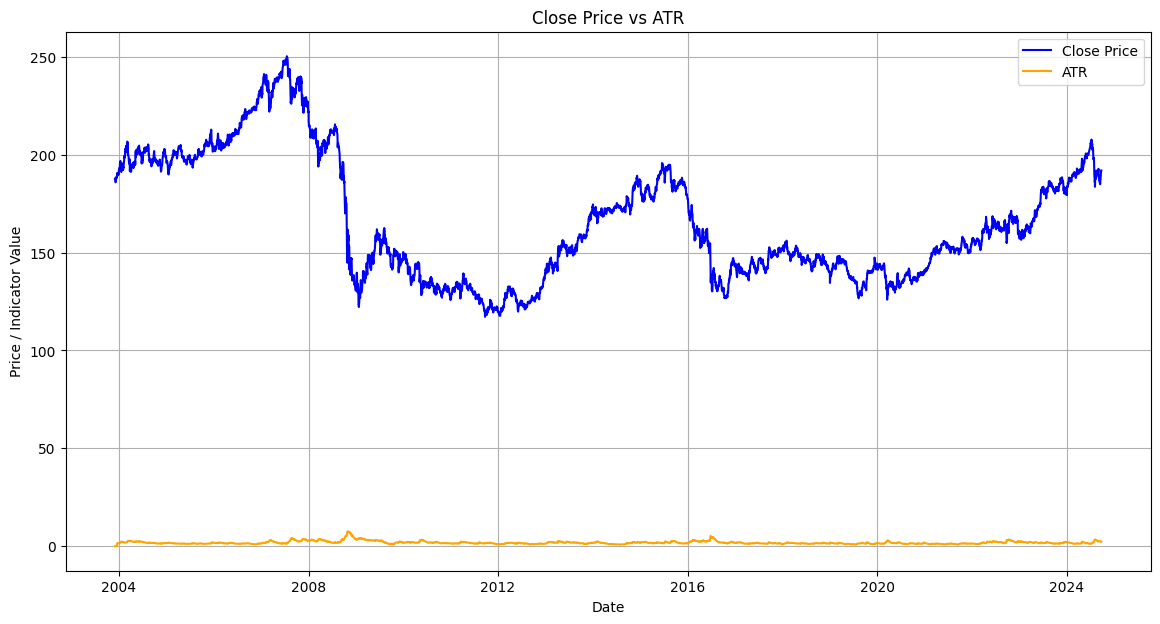

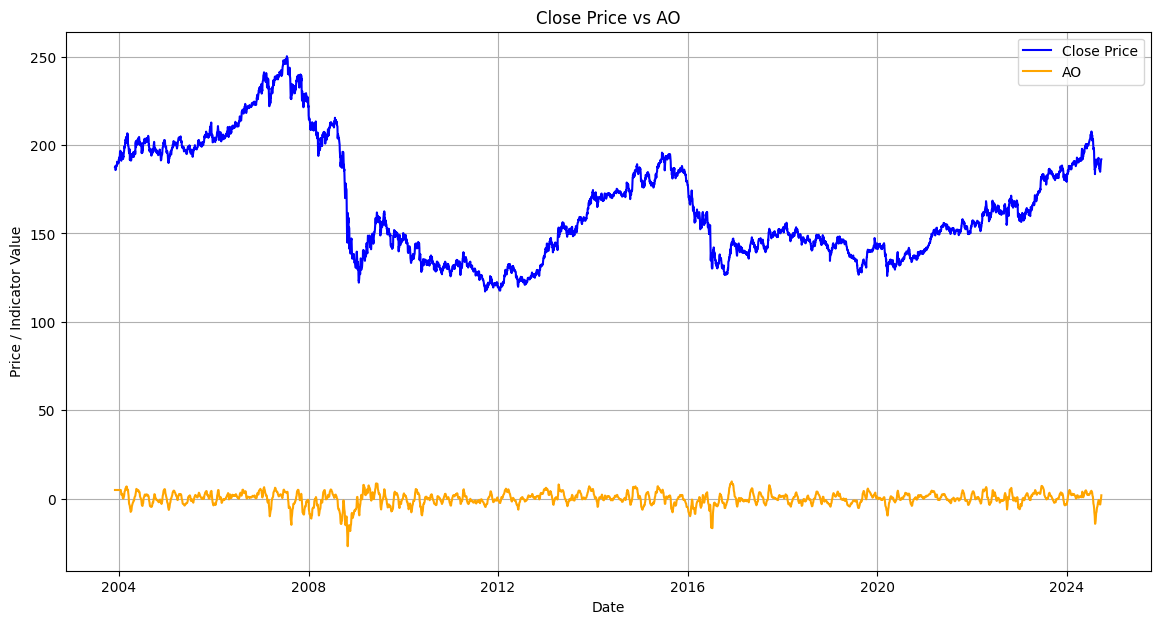

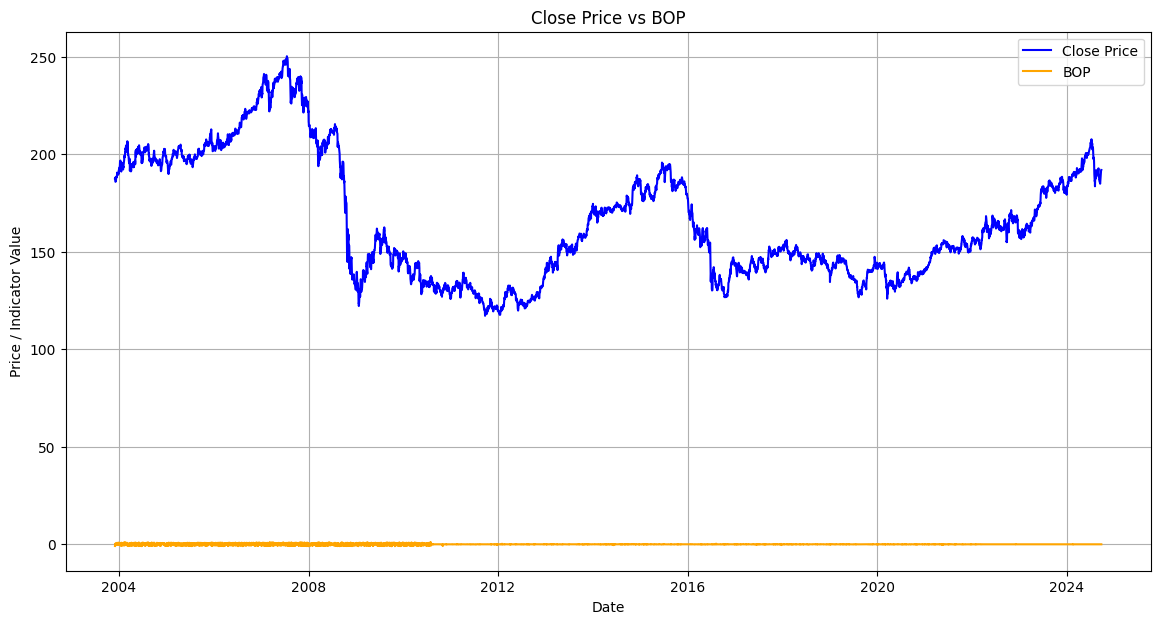

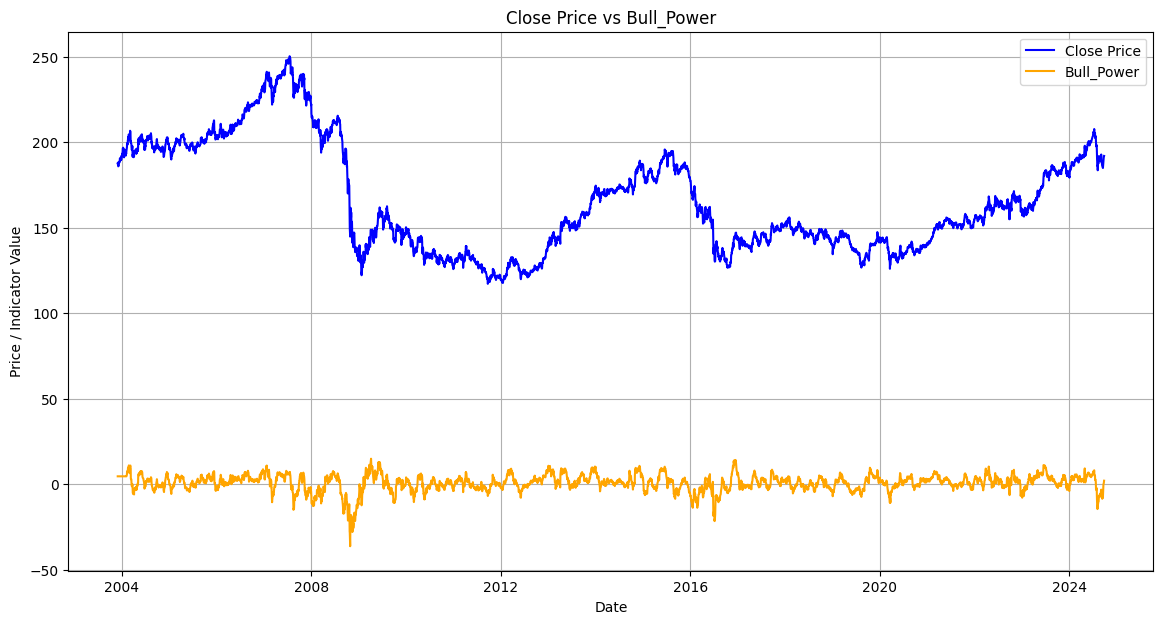

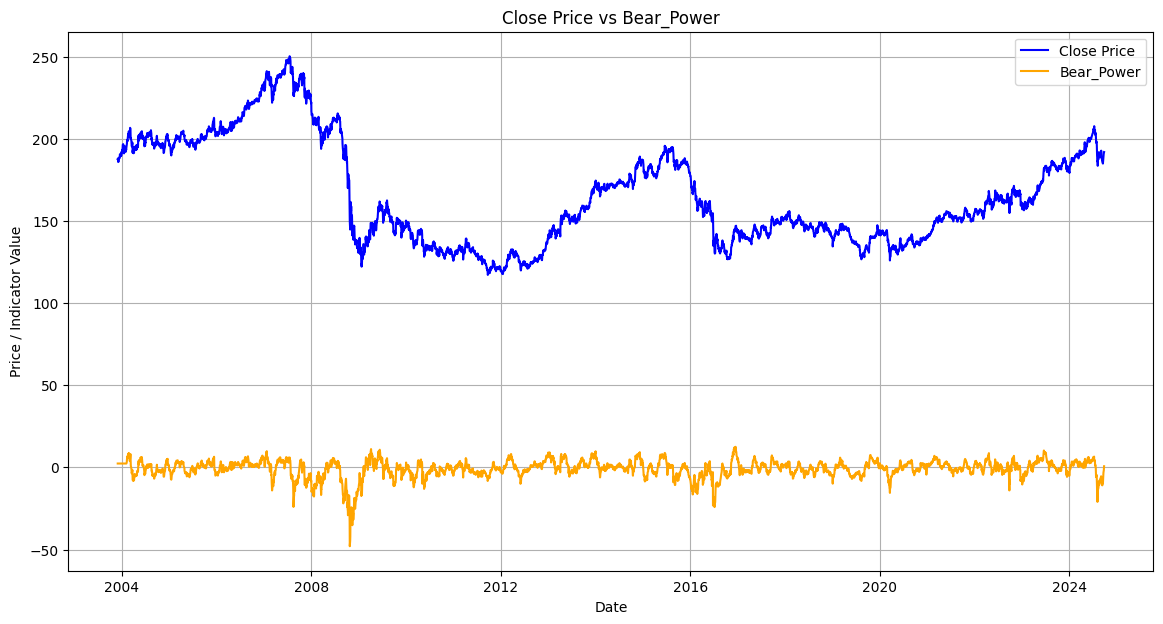

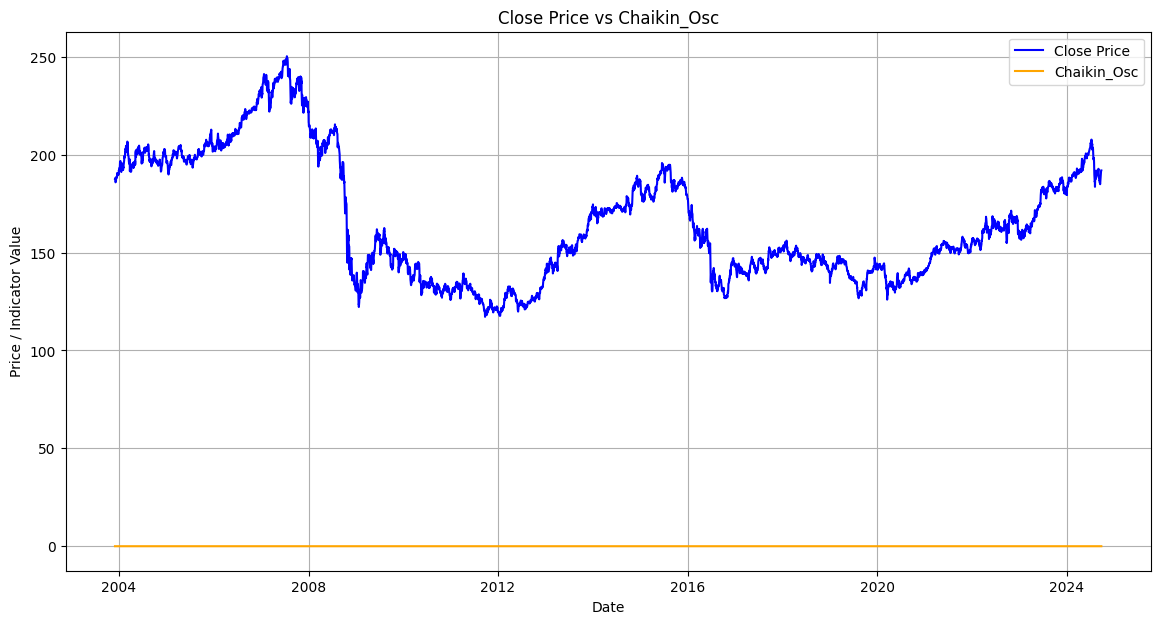

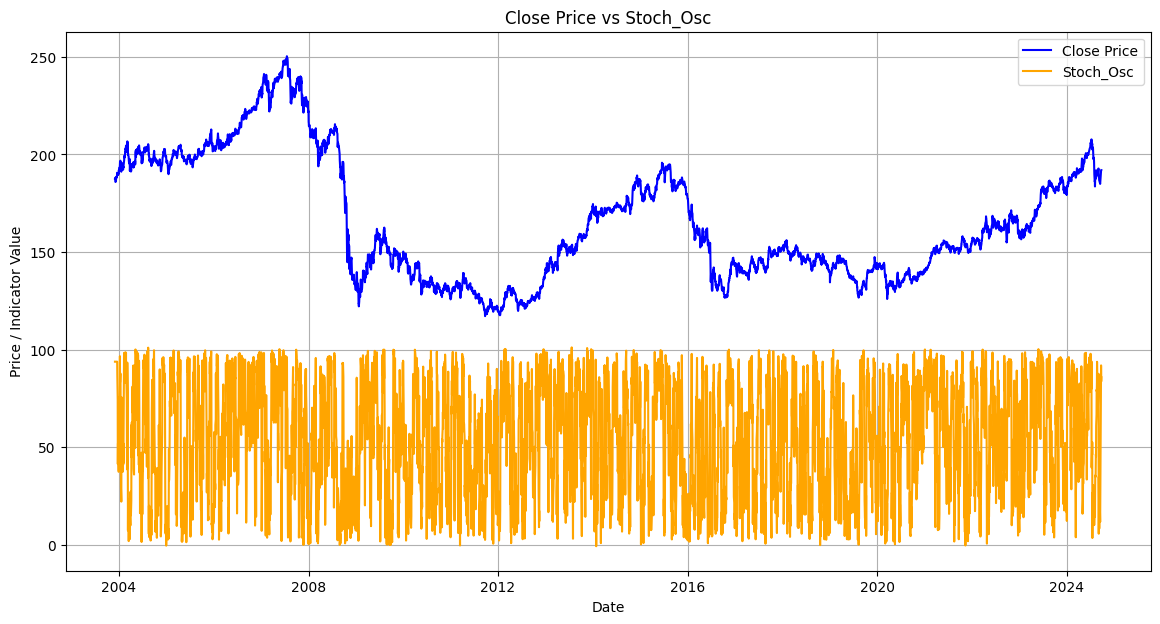

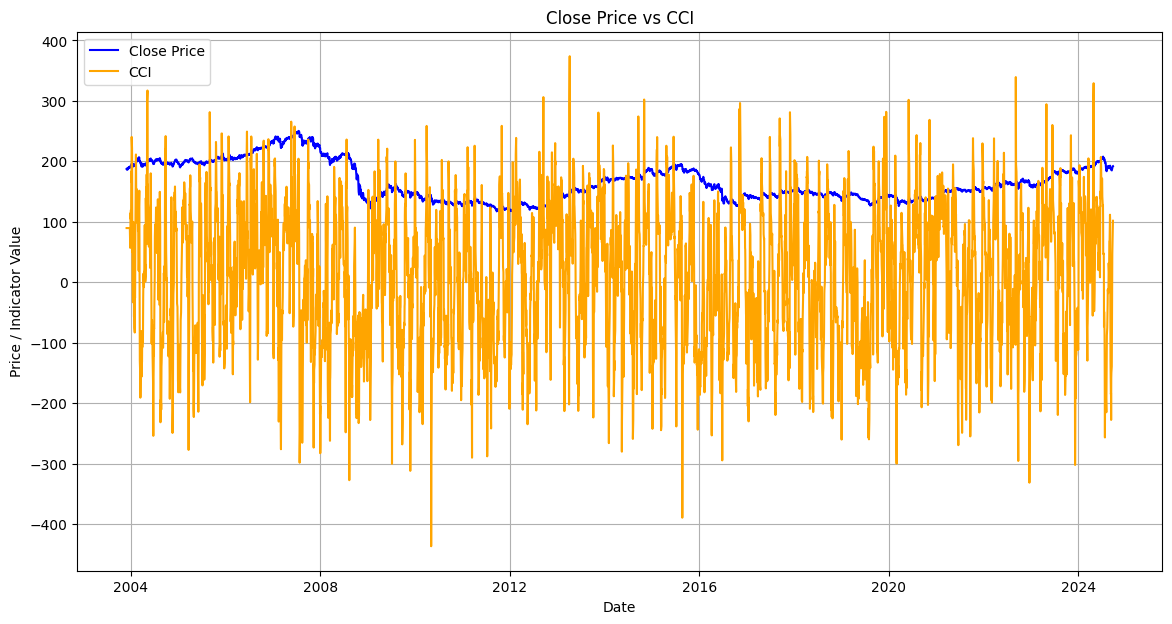

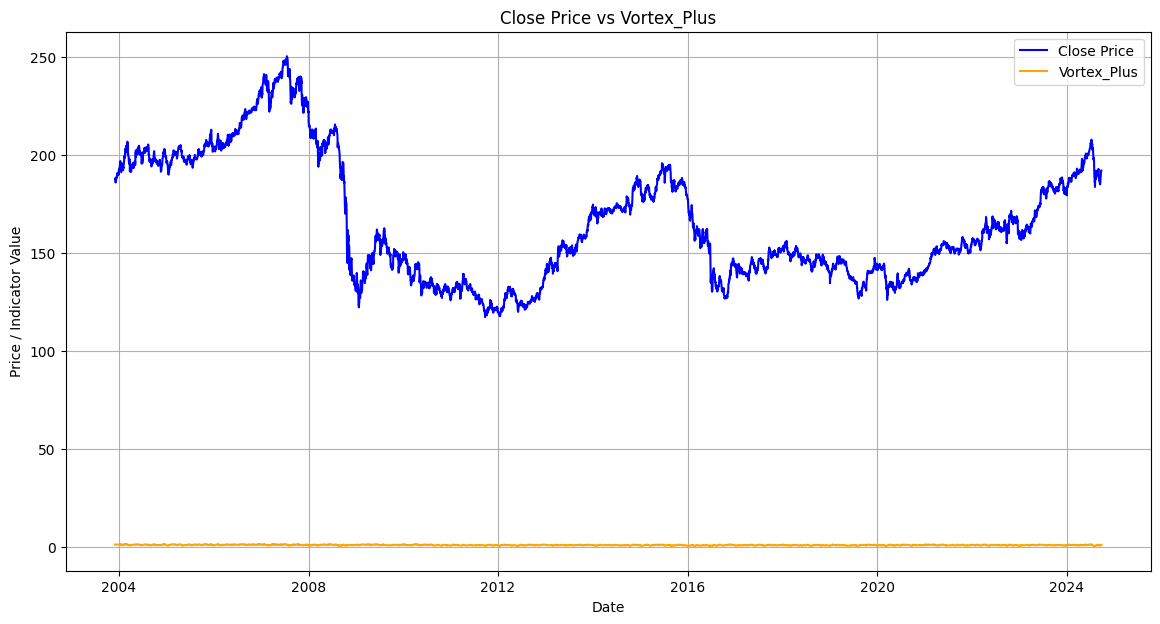

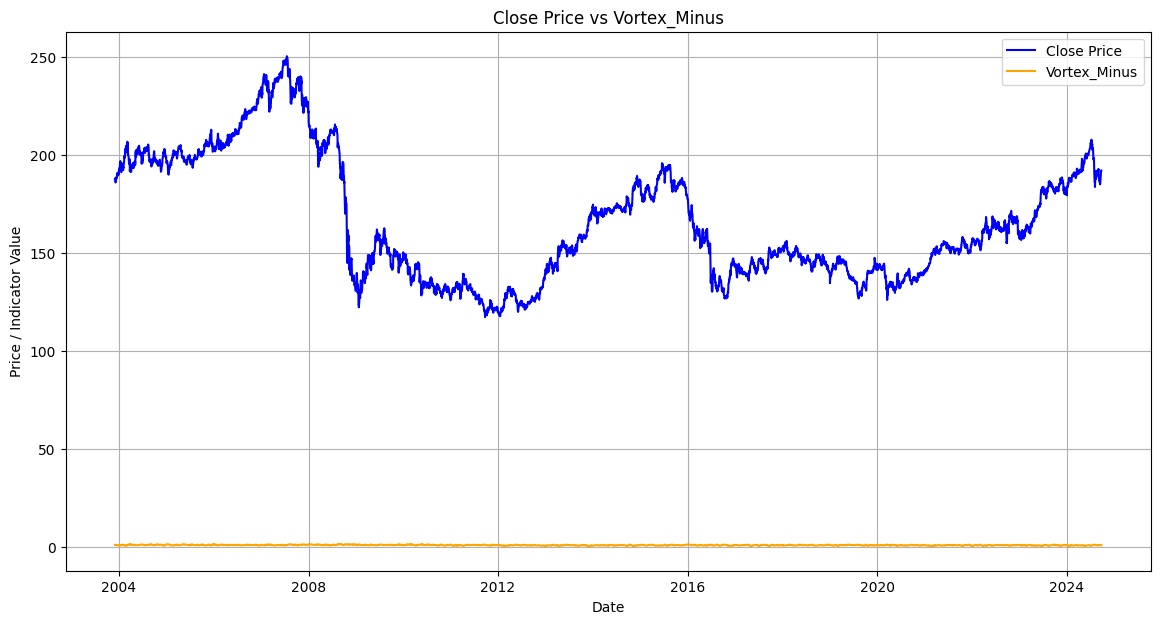

In [108]:
# Plot Close Price vs each indicator
for indicator in indicators:
    if indicator in data.columns:  # Check if the indicator exists
        plot_prices_vs_indicators(data, indicator, f'Close Price vs {indicator}')

# **STEP 5 FIND UN-RELATED FEATURES USING MUTUAL INFORMATION (MI)**

**5.1. Calculate MI and decide which feature has the highest correlation**

In [109]:
# Define the target variables
targets = ['Close', 'Open', 'High', 'Low']  # Add any other targets you want to consider

# Initialize a DataFrame to hold MI scores for each target
mi_results = pd.DataFrame()

# Separate features
X = data.drop(columns=['Date'] + targets)  # Exclude the target and date columns

# Calculate Mutual Information for each target variable
for target in targets:
    y = data[target]
    
    # Calculate Mutual Information
    mi_scores = mutual_info_regression(X, y)
    
    # Create a DataFrame for the current target's MI scores
    mi_df = pd.DataFrame(mi_scores, index=X.columns, columns=[f'MI Score_{target}'])
    
    # Append to the results DataFrame
    mi_results = pd.concat([mi_results, mi_df], axis=1)

# Set display options to avoid scientific notation
pd.set_option('display.float_format', '{:.6f}'.format)

# Display the MI scores for all targets
print("Mutual Information Scores for each target:")
print(mi_results)

Mutual Information Scores for each target:
              MI Score_Close  MI Score_Open  MI Score_High  MI Score_Low
Adj Close           7.317727       5.184688       3.905566      3.814093
Volume              0.000000       0.000000       0.000001      0.000002
MA_10               2.653263       2.713159       2.691321      2.631880
MA_50               2.108864       2.118179       2.193353      2.129579
MA_200              2.076387       2.085076       2.150373      2.095112
RSI                 0.209583       0.163729       0.164914      0.157853
MACD                0.384880       0.397058       0.385394      0.386208
BB_High             2.368477       2.404946       2.399457      2.372795
BB_Low              2.397896       2.424683       2.440331      2.364852
BB_Width            0.316057       0.306955       0.338229      0.308757
Volume_24h          0.000000       0.000000       0.000001      0.000002
ADL                 0.000000       0.000000       0.000000      0.000012
Aroon_Up

**5.2. Drop unrelated features**

In [110]:
# Define a threshold for MI score
mi_threshold = 0.25

# Identify features to drop based on the MI score for each target
features_to_drop = set()
for target in targets:
    low_mi_features = mi_results[mi_results[f'MI Score_{target}'] < mi_threshold].index.tolist()
    features_to_drop.update(low_mi_features)

# Drop the unrelated features from the DataFrame
X_reduced = X.drop(columns=list(features_to_drop))

# Optionally, update the DataFrame with the target
data_reduced = data.drop(columns=list(features_to_drop))

# Check the remaining features
print("Remaining features after dropping unrelated ones:")
print(X_reduced.columns)

# Save the reduced DataFrame if needed
reduced_file_path = os.path.join('Dataset', forex_label[0] + '_reduced_data.csv')
data_reduced.to_csv(reduced_file_path, index=False)
print(f"Saved reduced data to: {reduced_file_path}")
print(data.head(1000))

Remaining features after dropping unrelated ones:
Index(['Adj Close', 'MA_10', 'MA_50', 'MA_200', 'MACD', 'BB_High', 'BB_Low',
       'BB_Width', 'ATR', 'AO', 'BOP', 'Bull_Power', 'Bear_Power'],
      dtype='object')
Saved reduced data to: Dataset\GBPJPY=X_reduced_data.csv
          Date       Open       High        Low      Close  Adj Close  Volume  \
0   2003-12-01 189.330002 189.660004 187.740005 187.630005 187.630005       0   
1   2003-12-02 187.669998 188.809998 187.559998 188.009995 188.009995       0   
2   2003-12-03 188.020004 188.240005 186.490005 187.089996 187.089996       0   
3   2003-12-04 187.029999 187.029999 185.899994 186.220001 186.220001       0   
4   2003-12-05 186.190002 186.740005 185.830002 185.880005 185.880005       0   
..         ...        ...        ...        ...        ...        ...     ...   
995 2007-09-27 232.669998 234.449997 232.449997 234.130005 234.130005       0   
996 2007-09-28 234.080002 235.240005 232.479996 235.240005 235.240005       0 

# **STEP 6: PREPARE AND TRANSFORM DATA-FRAME**

In [111]:
class ColumnSelector(BaseEstimator, TransformerMixin):
    def __init__(self, feature_names):
        self.feature_names = feature_names

    def fit(self, dataframe, labels=None):
        return self

    def transform(self, dataframe):
        return dataframe[self.feature_names].values

**6.1. Shift Label for future predictions**

In [113]:
k = -1
for target_column in targets:  # Iterate over each target
    data[target_column] = data[target_column].shift(k)

# Drop rows with NaN values created by the shift
data = data.dropna()

# Print some data 
print(data.head())

        Date       Open       High        Low      Close  Adj Close  Volume  \
0 2003-12-01 187.669998 188.809998 187.559998 188.009995 187.630005       0   
1 2003-12-02 188.020004 188.240005 186.490005 187.089996 188.009995       0   
2 2003-12-03 187.029999 187.029999 185.899994 186.220001 187.089996       0   
3 2003-12-04 186.190002 186.740005 185.830002 185.880005 186.220001       0   
4 2003-12-05 185.949997 186.699997 185.589996 186.179993 185.880005       0   

       MA_10      MA_50     MA_200  ...      ATR       AO       BOP  \
0 187.290999 191.452800 197.364300  ... 0.000000 4.871175 -0.885416   
1 187.290999 191.452800 197.364300  ... 0.000000 4.871175  0.271997   
2 187.290999 191.452800 197.364300  ... 0.000000 4.871175 -0.531433   
3 187.290999 191.452800 197.364300  ... 0.000000 4.871175 -0.716809   
4 187.290999 191.452800 197.364300  ... 0.000000 4.871175 -0.340655   

   Bull_Power  Bear_Power  Chaikin_Osc  Stoch_Osc       CCI  Vortex_Plus  \
0    4.577199    2.357

**6.2. Split the data into training and test sets**

In [114]:
train_set, test_set = train_test_split(data, test_size=0.2, random_state=42)

# Print out some information about the split
print('\n____________ Split training and test set ____________')     
print(len(train_set), "training +", len(test_set), "test examples")
print(train_set.head(4))


____________ Split training and test set ____________
4335 training + 1084 test examples
           Date       Open       High        Low      Close  Adj Close  \
4715 2022-01-13 156.440002 156.509995 155.479996 156.477005 157.134995   
1231 2008-09-01 193.490005 194.770004 192.897003 193.580002 193.498993   
1586 2010-01-11 148.384995 148.593002 146.653000 147.074997 148.350006   
4675 2021-11-18 154.292999 154.442001 152.520004 154.259995 154.007004   

      Volume      MA_10      MA_50     MA_200  ...      ATR        AO  \
4715       0 156.583098 153.068499 152.858810  ... 1.287446  4.006158   
1231       0 201.204900 209.429660 210.380250  ... 2.118132 -9.114073   
1586       0 148.452002 147.076780 150.409305  ... 1.891911  2.032381   
4675       0 153.283601 153.415492 152.252220  ... 1.267027 -1.095142   

           BOP  Bull_Power  Bear_Power  Chaikin_Osc  Stoch_Osc         CCI  \
4715 -0.021326    4.380506    3.442502     0.000000  87.938897   79.703419   
1231 -0.696011  -

**6.3. Define features and targets**

In [115]:
feature_columns = data.columns.difference(['Date'] + targets).tolist()  # Define features excluding Date and targets
X_reduced = data.drop(columns=['Date'] + targets).drop(columns=list(features_to_drop))  

In [116]:
X_train = train_set[X_reduced.columns]
X_test = test_set[X_reduced.columns]

# Split targets for each label
y_train_dict = {target: train_set[target] for target in targets}
y_test_dict = {target: test_set[target] for target in targets}

**6.4. Define and Train Model Pipelines for Each Target**

In [119]:

# Redefine num_feat_names based on X_reduced
num_feat_names = X_reduced.columns.tolist()

In [123]:
num_pipeline = Pipeline(steps=[
    ('selector', ColumnSelector(num_feat_names)),
    ('imputer', SimpleImputer(missing_values=np.nan, strategy='mean')),
    ('scaler', StandardScaler(with_mean=True, with_std=True))
])


**6.4.2. Fit and Transform the Pipeline on training data**

In [124]:

# Run the pipeline to process training data
processed_train_set_val = num_pipeline.fit_transform(X_train)

# Fit the pipeline on training data and transform both training and test data
X_train = num_pipeline.fit_transform(X_train)
X_test = num_pipeline.transform(X_test)

# Convert the transformed data back to DataFrame with appropriate column names
X_train = pd.DataFrame(X_train, columns=num_feat_names)
X_test = pd.DataFrame(X_test, columns=num_feat_names)

print('\n____________ Processed feature values ____________')
print(processed_train_set_val[:3, :])  # Print out some of the first rows of the training dataset after fit_transforming
print(processed_train_set_val.shape)  # Print out the statistics of the training set

# Save the numerical pipeline
joblib.dump(num_pipeline, r'models/num_pipeline.pkl')


____________ Processed feature values ____________
[[-0.27085937 -0.28855381 -0.40626796 -0.42675616  0.95923882 -0.31973639
  -0.38789583  0.4321718  -0.72285799  1.10691561 -0.11272878  0.74713291
   0.80399968]
 [ 0.90056732  1.1509913   1.41999152  1.48205216 -2.48627694  1.45335565
   1.07936087  1.79799961  0.36833445 -2.51846723 -2.34207375 -2.73420318
  -2.96010722]
 [-0.55385822 -0.55087131 -0.60041644 -0.50804127  0.45185444 -0.60730529
  -0.5698642  -0.18962748  0.07116995  0.56152139 -0.47961617  0.35675792
   0.33906166]]
(4335, 13)


['models/num_pipeline.pkl']

# **STEP 7. TRAIN AND EVALUATE MODEL**

**Function to calculate R2 score and Root Mean Squared Error.**

In [125]:
def r2score_and_rmse(model, train_data, labels): 
    r2score = model.score(train_data, labels)
    from sklearn.metrics import mean_squared_error
    prediction = model.predict(train_data)
    mse = mean_squared_error(labels, prediction)
    rmse = np.sqrt(mse)
    return r2score, rmse

**Function to Store and Load Models.**

In [126]:
def store_model(model, model_name = ""):
    # NOTE: sklearn.joblib faster than pickle of Python
    # INFO: can store only ONE object in a file
    if model_name == "": 
        model_name = type(model).__name__
    joblib.dump(model,'models/' + model_name + '_model.pkl')
    print(f"Model successfully saved as " + model_name + '_model.pkl')
    
def load_model(model_name):
    # Load objects into memory
    #del model
    model = joblib.load('models/' + model_name + '_model.pkl')
    #print(model)
    return model

**7.1. Try Light GBM model.**

In [127]:
for target in targets:
    model = lgb.LGBMRegressor()  # Initialize the model
    model.fit(X_train, y_train_dict[target])  # Fit the model on the respective target

    print(f'\n____________ LGBMRegressor for {target} ____________')

    r2score, rmse = r2score_and_rmse(model, X_train, y_train_dict[target])
    print('\nR2 score (on training data, best=1):', r2score)
    print("Root Mean Square Error: ", rmse)

    # Predict labels for some test instances
    print("\nPredictions: ", model.predict(X_test[:9]))
    print("Labels:      ", list(y_test_dict[target][:9]))

    store_model(model)  # Store the model for the current target

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000504 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3315
[LightGBM] [Info] Number of data points in the train set: 4335, number of used features: 13
[LightGBM] [Info] Start training from score 165.544492

____________ LGBMRegressor for Close ____________

R2 score (on training data, best=1): 0.9991500638376182
Root Mean Square Error:  0.9044510179255675

Predictions:  [137.36759988 150.48456766 198.62610923 194.0099599  165.81432486
 201.19213887 172.33320579 171.44850567 132.01670304]
Labels:       [138.11199951171875, 150.44400024414062, 198.6699981689453, 192.07000732421875, 165.66200256347656, 202.0189971923828, 174.32200622558594, 170.05999755859375, 131.95700073242188]
Model successfully saved as LGBMR

**7.2. Try XGBoost model.**

In [129]:
for target in targets:
    model = XGBRegressor() # Initialize the model
    model.fit(X_train, y_train_dict[target])  # Fit the model on the respective target

    print(f'\n____________ XGBoost_Regressor for {target} ____________')

    r2score, rmse = r2score_and_rmse(model, X_train, y_train_dict[target])
    print('\nR2 score (on training data, best=1):', r2score)
    print("Root Mean Square Error: ", rmse)

    # Predict labels for some test instances
    print("\nPredictions: ", model.predict(X_test[:9]))
    print("Labels:      ", list(y_test_dict[target][:9]))

    store_model(model)  # Store the model for the current target


____________ XGBoost_Regressor for Close ____________

R2 score (on training data, best=1): 0.9998079018921276
Root Mean Square Error:  0.42998513478861144

Predictions:  [137.47633 149.97833 198.84325 194.16971 165.96323 201.20146 171.84915
 171.72804 132.3343 ]
Labels:       [138.11199951171875, 150.44400024414062, 198.6699981689453, 192.07000732421875, 165.66200256347656, 202.0189971923828, 174.32200622558594, 170.05999755859375, 131.95700073242188]
Model successfully saved as XGBRegressor_model.pkl

____________ XGBoost_Regressor for Open ____________

R2 score (on training data, best=1): 0.9998847008077353
Root Mean Square Error:  0.33324807715344446

Predictions:  [137.5854  150.31564 198.3234  193.63802 165.76657 201.43083 171.99286
 171.52843 131.94156]
Labels:       [138.1009979248047, 150.06900024414062, 198.10000610351562, 193.3000030517578, 165.66200256347656, 202.0189971923828, 174.3159942626953, 169.99000549316406, 131.97000122070312]
Model successfully saved as XGBRegre

**7.3. Try Decision Tree (in-lecture).**

In [135]:
for target in targets:
    model = DecisionTreeRegressor() # Initialize the model
    model.fit(X_train, y_train_dict[target])  # Fit the model on the respective target

    print(f'\n____________ DecisionTreeRegressor for {target} ____________')

    r2score, rmse = r2score_and_rmse(model, X_train, y_train_dict[target])
    print('\nR2 score (on training data, best=1):', r2score)
    print("Root Mean Square Error: ", rmse)

    # Predict labels for some test instances
    print("\nPredictions: ", model.predict(X_test[:9]))
    print("Labels:      ", list(y_test_dict[target][:9]))

    store_model(model)  # Store the model for the current target


____________ DecisionTreeRegressor for Close ____________

R2 score (on training data, best=1): 1.0
Root Mean Square Error:  0.0

Predictions:  [137.53999329 150.27999878 198.60499573 196.11999512 165.97799683
 201.3500061  171.93699646 170.73599243 131.97599792]
Labels:       [138.11199951171875, 150.44400024414062, 198.6699981689453, 192.07000732421875, 165.66200256347656, 202.0189971923828, 174.32200622558594, 170.05999755859375, 131.95700073242188]
Model successfully saved as DecisionTreeRegressor_model.pkl

____________ DecisionTreeRegressor for Open ____________

R2 score (on training data, best=1): 1.0
Root Mean Square Error:  0.0

Predictions:  [136.92399597 150.72549438 198.13000488 192.71000671 165.83999634
 200.91999817 171.8480072  171.227005   132.60800171]
Labels:       [138.1009979248047, 150.06900024414062, 198.10000610351562, 193.3000030517578, 165.66200256347656, 202.0189971923828, 174.3159942626953, 169.99000549316406, 131.97000122070312]
Model successfully saved as

**7.4. Try Polynomial Regression (in-lecture).**

In [132]:
for target in targets:
    degree = 2  # Degree of the polynomial
    model = Pipeline([
        ('poly_features', PolynomialFeatures(degree=degree)),
        ('lin_reg', LinearRegression())
    ])

    # Fit the model on the respective target
    model.fit(X_train, y_train_dict[target])

    print(f'\n____________ PolynomialRegressor for {target} ____________')

    r2score, rmse = r2score_and_rmse(model, X_train, y_train_dict[target])
    print('\nR2 score (on training data, best=1):', r2score)
    print("Root Mean Square Error: ", rmse)

    # Predict labels for some test instances
    predictions = model.predict(X_test[:9]).round(decimals=1)
    print("\nPredictions: ", predictions)
    print("Labels:      ", list(y_test_dict[target][:9]))

    store_model(model)  # Store the model for the current target


____________ PolynomialRegressor for Close ____________

R2 score (on training data, best=1): 0.9989338318698053
Root Mean Square Error:  1.0129890394308017

Predictions:  [138.  150.1 197.9 192.9 166.  201.1 173.3 170.5 131.2]
Labels:       [138.11199951171875, 150.44400024414062, 198.6699981689453, 192.07000732421875, 165.66200256347656, 202.0189971923828, 174.32200622558594, 170.05999755859375, 131.95700073242188]
Model successfully saved as Pipeline_model.pkl

____________ PolynomialRegressor for Open ____________

R2 score (on training data, best=1): 0.9996705613447102
Root Mean Square Error:  0.5633026548512192

Predictions:  [138.  150.2 197.9 192.9 165.9 201.1 173.5 170.4 131.2]
Labels:       [138.1009979248047, 150.06900024414062, 198.10000610351562, 193.3000030517578, 165.66200256347656, 202.0189971923828, 174.3159942626953, 169.99000549316406, 131.97000122070312]
Model successfully saved as Pipeline_model.pkl

____________ PolynomialRegressor for High ____________

R2 score

**7.5. Try Linear Regressor (in-lecture).**

In [136]:
for target in targets:
    model = LinearRegression() # Initialize the model
    model.fit(X_train, y_train_dict[target])  # Fit the model on the respective target

    print(f'\n____________ Linear Regressor for {target} ____________')

    r2score, rmse = r2score_and_rmse(model, X_train, y_train_dict[target])
    print('\nR2 score (on training data, best=1):', r2score)
    print("Root Mean Square Error: ", rmse)

    # Predict labels for some test instances
    print("\nPredictions: ", model.predict(X_test[:9]))
    print("Labels:      ", list(y_test_dict[target][:9]))

    store_model(model)  # Store the model for the current target


____________ Linear Regressor for Close ____________

R2 score (on training data, best=1): 0.9986302733651523
Root Mean Square Error:  1.1481770146869406

Predictions:  [138.09524046 150.0930354  197.48431478 193.31537509 166.22292254
 201.25911725 173.21794438 171.29030868 131.93097636]
Labels:       [138.11199951171875, 150.44400024414062, 198.6699981689453, 192.07000732421875, 165.66200256347656, 202.0189971923828, 174.32200622558594, 170.05999755859375, 131.95700073242188]
Model successfully saved as LinearRegression_model.pkl

____________ Linear Regressor for Open ____________

R2 score (on training data, best=1): 0.9994640234304404
Root Mean Square Error:  0.7185010748581871

Predictions:  [138.05581191 150.1211427  197.40247376 193.3402588  166.22940016
 201.21296069 173.44261134 171.28462369 131.93770004]
Labels:       [138.1009979248047, 150.06900024414062, 198.10000610351562, 193.3000030517578, 165.66200256347656, 202.0189971923828, 174.3159942626953, 169.99000549316406, 13

**7.6. Try Random Forest (in-lecture).**

In [139]:
for target in targets:
    model = RandomForestRegressor(n_estimators=20) # Initialize the model
    model.fit(X_train, y_train_dict[target])  # Fit the model on the respective target

    print(f'\n____________ RandomForestRegressor for {target} ____________')

    r2score, rmse = r2score_and_rmse(model, X_train, y_train_dict[target])
    print('\nR2 score (on training data, best=1):', r2score)
    print("Root Mean Square Error: ", rmse)

    # Predict labels for some test instances
    print("\nPredictions: ", model.predict(X_test[:9]))
    print("Labels:      ", list(y_test_dict[target][:9]))

    store_model(model)  # Store the model for the current target


____________ RandomForestRegressor for Close ____________

R2 score (on training data, best=1): 0.9997076992953422
Root Mean Square Error:  0.5304040471645526

Predictions:  [137.67644882 150.16475067 198.34149933 193.25500183 165.53929901
 200.89434891 171.87565231 171.66219788 132.07150116]
Labels:       [138.11199951171875, 150.44400024414062, 198.6699981689453, 192.07000732421875, 165.66200256347656, 202.0189971923828, 174.32200622558594, 170.05999755859375, 131.95700073242188]
Model successfully saved as RandomForestRegressor_model.pkl

____________ RandomForestRegressor for Open ____________

R2 score (on training data, best=1): 0.9998506252293607
Root Mean Square Error:  0.3793089982794767

Predictions:  [137.52530289 150.51455078 198.34499817 193.44715118 165.93599854
 201.24179993 172.6364502  171.3781517  131.95049973]
Labels:       [138.1009979248047, 150.06900024414062, 198.10000610351562, 193.3000030517578, 165.66200256347656, 202.0189971923828, 174.3159942626953, 169.990

**7.7. Try K-Nearest-Neighbor**

In [144]:
for target in targets:
    model = KNeighborsRegressor(n_neighbors=5) # Initialize the model
    model.fit(X_train, y_train_dict[target])  # Fit the model on the respective target

    print(f'\n____________ KNeighborRegressor for {target} ____________')

    r2score, rmse = r2score_and_rmse(model, X_train, y_train_dict[target])
    print('\nR2 score (on training data, best=1):', r2score)
    print("Root Mean Square Error: ", rmse)

    # Predict labels for some test instances
    print("\nPredictions: ", model.predict(X_test[:9]))
    print("Labels:      ", list(y_test_dict[target][:9]))

    store_model(model)  # Store the model for the current target


____________ KNeighborRegressor for Close ____________

R2 score (on training data, best=1): 0.997291954312884
Root Mean Square Error:  1.6144324994051122

Predictions:  [137.65415955 146.24239807 199.62200012 194.78400269 166.56600037
 201.12559814 168.52680054 171.11759644 131.69779968]
Labels:       [138.11199951171875, 150.44400024414062, 198.6699981689453, 192.07000732421875, 165.66200256347656, 202.0189971923828, 174.32200622558594, 170.05999755859375, 131.95700073242188]
Model successfully saved as KNeighborsRegressor_model.pkl

____________ KNeighborRegressor for Open ____________

R2 score (on training data, best=1): 0.997666734374173
Root Mean Square Error:  1.499120735535937

Predictions:  [137.60520325 145.9552002  199.18799744 194.62399902 166.56600037
 201.13320007 168.51099548 171.13440247 131.69699707]
Labels:       [138.1009979248047, 150.06900024414062, 198.10000610351562, 193.3000030517578, 165.66200256347656, 202.0189971923828, 174.3159942626953, 169.99000549316406

**7.8. Try using SVR**

In [145]:
for target in targets:
    model = SVR(kernel='rbf')  # Initialize the model
    model.fit(X_train, y_train_dict[target])  # Fit the model on the respective target

    print(f'\n____________ Support Vector Regressor (SVR) for {target} ____________')

    r2score, rmse = r2score_and_rmse(model, X_train, y_train_dict[target])
    print('\nR2 score (on training data, best=1):', r2score)
    print("Root Mean Square Error: ", rmse)

    # Predict labels for some test instances
    print("\nPredictions: ", model.predict(X_test[:9]))
    print("Labels:      ", list(y_test_dict[target][:9]))

    store_model(model)  # Store the model for the current target


____________ Support Vector Regressor (SVR) for Close ____________

R2 score (on training data, best=1): 0.9853453225018031
Root Mean Square Error:  3.7556060568623932

Predictions:  [136.7932563  150.33283365 197.64517796 192.72241952 166.1501566
 200.45571516 172.60210487 170.9946273  131.58512792]
Labels:       [138.11199951171875, 150.44400024414062, 198.6699981689453, 192.07000732421875, 165.66200256347656, 202.0189971923828, 174.32200622558594, 170.05999755859375, 131.95700073242188]
Model successfully saved as SVR_model.pkl

____________ Support Vector Regressor (SVR) for Open ____________

R2 score (on training data, best=1): 0.9857907041890338
Root Mean Square Error:  3.699480969141545

Predictions:  [136.77927106 150.20250217 197.30750367 192.58026127 166.14444011
 200.31976729 172.62828521 171.03838226 131.60037533]
Labels:       [138.1009979248047, 150.06900024414062, 198.10000610351562, 193.3000030517578, 165.66200256347656, 202.0189971923828, 174.3159942626953, 169.99000

# **STEP 8: EVALUATE WITH K-CROSS VALIDATION:**

In [161]:
print('\n____________ K-fold cross validation ____________')
cv = KFold(n_splits=5, shuffle=True, random_state=37)  # cv data generator

run_new_evaluation = 1  # Set to 1 for new evaluation; 0 to load results
filename_prefix = "your_prefix"  # Change this to your desired prefix

if run_new_evaluation:
    for target in targets:
        # Evaluate Linear Regression
        model_name = "LinearRegression"
        model = LinearRegression()
        
        # Using one of the targets (for example, y_train_dict[target])
        y_train = y_train_dict[target]
        
        nmse_scores = cross_val_score(model, X_train, y_train, cv=cv, scoring='neg_mean_squared_error')
        rmse_scores = np.sqrt(-nmse_scores)
        
        # Save RMSE scores
        joblib.dump(rmse_scores, f'saved_objects/{model_name}_rmse_{target}.pkl')
        print(f"{target} - LinearRegression rmse: ", rmse_scores)
        print(f"{target} - Avg. rmse: ", mean(rmse_scores), '\n')

        # Step 2: Predict using cross-validation
        y_train_pred = cross_val_predict(model, X_train, y_train, cv=cv)
        
        # Step 3: Calculate residuals
        residuals = y_train - y_train_pred
        
        # Step 4: Plot the residual distribution
        plt.figure()
        plt.hist(residuals, bins=30, edgecolor='black', alpha=0.7)
        plt.title(f'{target} - Linear Regression Residual Distribution')
        plt.xlabel('Residuals')
        plt.ylabel('Frequency')
        plt.grid(True)
        plt.savefig(f'models/{filename_prefix}_{target}_residuals_plot.png')  # Save with target name
        plt.close()  # Close the plot to free memory
else: 
    # Load LinearRegression RMSE
    for target in targets:
        model_name = "LinearRegression" 
        rmse_scores = joblib.load(f'saved_objects/{model_name}_rmse_{target}.pkl')
        print("\nLinearRegression rmse for", target, ": ", rmse_scores)
        print("Avg. rmse: ", mean(rmse_scores), '\n')

        # Load and show the residual distribution plot
        img = plt.imread(f'models/{filename_prefix}_{target}_residuals_plot.png')
        plt.imshow(img)
        plt.axis('off')
        plt.title(f'{target} - Residuals Distribution Plot')
        plt.show()



____________ K-fold cross validation ____________


Close - LinearRegression rmse:  [1.25301701 1.0813323  1.06616826 1.22719441 1.18546311]
Close - Avg. rmse:  1.1626350153910616 

Open - LinearRegression rmse:  [0.69553292 0.7005733  0.71081766 0.71041999 0.79542576]
Open - Avg. rmse:  0.722553927779452 

High - LinearRegression rmse:  [1.00714311 0.93132919 0.97567032 1.0817571  1.07285325]
High - Avg. rmse:  1.0137505933540574 

Low - LinearRegression rmse:  [1.13920937 1.04866056 1.31054344 1.33977624 1.1150898 ]
Low - Avg. rmse:  1.190655882222857 

